In [63]:
#import sys
#sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [64]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [65]:
# the physics-guided neural network Inverse Problem

class PhysicsInformedNN_IP():
    def __init__(self, x,t, Y_obs,layers, alpha1, alpha2):
        
        # boundary conditions
        self.alpha1 = torch.nn.Parameter(torch.tensor(alpha1, requires_grad=True).float().to(device))
        self.alpha2 = torch.nn.Parameter(torch.tensor(alpha2, requires_grad=True).float().to(device))


        self.loss_function = torch.nn.MSELoss(reduction ='mean')

        # data
        self.x = torch.tensor(x, requires_grad=True).float().to(device)
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.Y_obs = torch.tensor(Y_obs).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter("alpha1", self.alpha1)
        self.dnn.register_parameter("alpha2", self.alpha2)

        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=0.1, 
            max_iter=50000, 
            max_eval=None, 
            tolerance_grad=1e-11, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t + (self.alpha1)*u*u_x - (self.alpha2)*u_xx 
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        f_hat = torch.zeros_like(self.x)

        loss_u = self.loss_function(self.Y_obs,u_pred)
        loss_f = self.loss_function(f_pred,f_hat)

        #loss_u = torch.mean((self.Y_obs - u_pred) ** 2)
        #loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Alphas: [%.5f, %.5f]' 
                    % (self.iter, loss.item(), loss_u.item(), loss_f.item(),self.alpha1.item(),self.alpha2.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [66]:
N_u = 15000

layers = [2] + 10*[20] + [1]

data = scipy.io.loadmat('burgers_shock.mat')

x = data['x'].flatten()[:,None]
t = data['t'].flatten()[:,None]
#Exact = data['usol'].flatten()[:,None]mochte
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

Y_obs = Exact.flatten()[:,None]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

total_points=len(x)*len(t)

idx = np.random.choice(total_points, N_u, replace=False)

X_star_train = X_star[idx,:]
Y_obs_train = Y_obs[idx,:]

x_train = X_star_train[:,0:1]
t_train = X_star_train[:,1:2]

In [67]:
model = PhysicsInformedNN_IP(x_train, t_train, Y_obs_train, layers, 2.0,-2.0)

In [68]:
model.train()

Iter 100, Loss: 2.67951e-01, Loss_u: 2.63728e-01, Loss_f: 4.22267e-03, Alphas: [1.82666, -1.62705]
Iter 200, Loss: 2.56400e-01, Loss_u: 2.53597e-01, Loss_f: 2.80261e-03, Alphas: [0.78739, -2.12855]
Iter 300, Loss: 2.48550e-01, Loss_u: 2.47239e-01, Loss_f: 1.31080e-03, Alphas: [-0.01499, -2.44051]
Iter 400, Loss: 2.45009e-01, Loss_u: 2.44791e-01, Loss_f: 2.17204e-04, Alphas: [-0.59363, -2.83984]
Iter 500, Loss: 2.41672e-01, Loss_u: 2.40725e-01, Loss_f: 9.46423e-04, Alphas: [-2.13078, -3.24820]
Iter 600, Loss: 2.37894e-01, Loss_u: 2.37005e-01, Loss_f: 8.89414e-04, Alphas: [-3.98197, -3.77656]
Iter 700, Loss: 2.35499e-01, Loss_u: 2.34724e-01, Loss_f: 7.75176e-04, Alphas: [-4.93922, -4.01280]
Iter 800, Loss: 2.33794e-01, Loss_u: 2.33245e-01, Loss_f: 5.48601e-04, Alphas: [-5.97116, -4.37398]
Iter 900, Loss: 2.33061e-01, Loss_u: 2.32380e-01, Loss_f: 6.80870e-04, Alphas: [-6.88705, -4.70460]
Iter 1000, Loss: 2.32210e-01, Loss_u: 2.31729e-01, Loss_f: 4.81111e-04, Alphas: [-7.39774, -4.83533]
I

In [69]:
u_pred, f_pred = model.predict(X_star)
#u_star = Exact.flatten()[:,None]

#error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

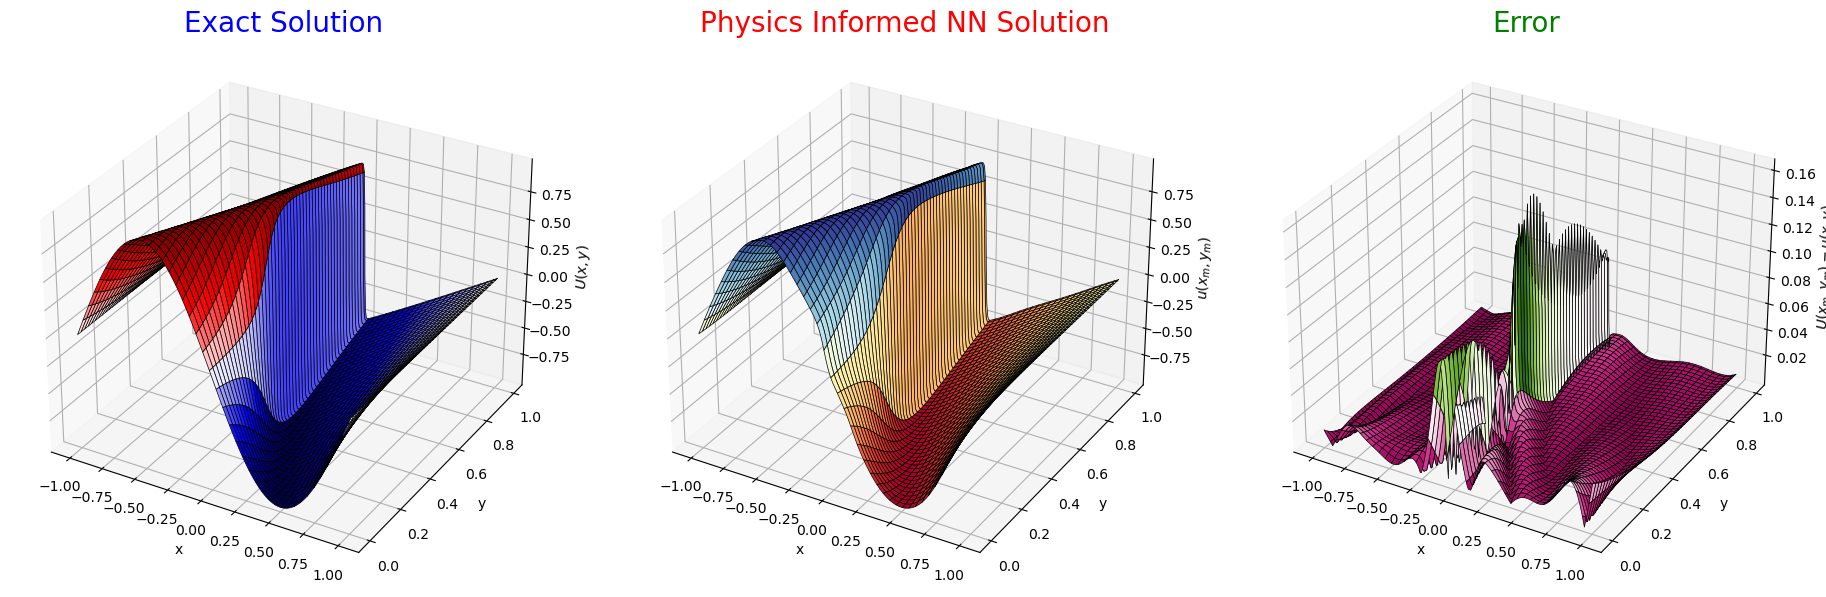

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm



# Plotting
fig = plt.figure(figsize=(25,12))



ax = fig.add_subplot(211, projection='3d')

ax.set_title("Physics Informed NN Solution", fontsize=20,color="red")

ax.plot_surface(X, T, U_pred, cmap=cm.RdYlBu, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$u(x_{m},y_{m})$",fontsize = 10)


ax = fig.add_subplot(221, projection='3d')

ax.set_title("Exact Solution", fontsize=20,color="blue")

ax.plot_surface(X, T, Exact, cmap=cm.seismic, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$U(x,y)$",fontsize = 10)



ax = fig.add_subplot(222, projection='3d')

ax.set_title("Error", fontsize=20,color="green")

ax.plot_surface(X, T, Error, cmap=cm.PiYG, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$U(x_{m},y_{m}) - u(x,y)$",fontsize = 10)


plt.tight_layout()
plt.show()

In [74]:
nPoints = [100,1000,5000,10000,15000,17500]
mean_er = np.zeros(len(nPoints))
mean_alpha1 = np.zeros(len(nPoints))
mean_alpha2 = np.zeros(len(nPoints))


iters = 10

for i,Nu in enumerate(nPoints):
    er = np.zeros(iters)
    alpha1 = np.zeros(iters); alpha2 = np.zeros(iters)

    for j in range(iters):

        idx = np.random.choice(total_points, Nu, replace=False)

        X_star_train = X_star[idx,:]
        Y_obs_train = Y_obs[idx,:] 

        #Y_obs_train = Y_obs_train + np.random.normal(mu, std, size = Y_obs_train.shape)

        x_train = X_star_train[:,0:1]
        t_train = X_star_train[:,1:2]

        model = PhysicsInformedNN_IP(x_train, t_train, Y_obs_train, layers, 2.0,-2.0)

        model.train()

        u_pred, f_pred = model.predict(X_star)                  

        U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

        er[j] = np.linalg.norm(Exact - U_pred)
        alpha1[j] = model.alpha1.item(); alpha2[j] = model.alpha2.item()

    mean_er[i] = np.nanmean(er)
    mean_alpha1[i] = np.nanmean(alpha1)
    mean_alpha2[i] = np.nanmean(alpha2)

Iter 100, Loss: 3.18730e-01, Loss_u: 3.11004e-01, Loss_f: 7.72519e-03, Alphas: [1.85306, -1.52033]
Iter 200, Loss: 2.85068e-01, Loss_u: 2.83230e-01, Loss_f: 1.83765e-03, Alphas: [0.12124, -2.65544]
Iter 300, Loss: 2.74181e-01, Loss_u: 2.72974e-01, Loss_f: 1.20762e-03, Alphas: [-0.61887, -2.93338]
Iter 400, Loss: 2.71332e-01, Loss_u: 2.70605e-01, Loss_f: 7.26742e-04, Alphas: [-1.07153, -3.14994]
Iter 500, Loss: 2.70001e-01, Loss_u: 2.68908e-01, Loss_f: 1.09273e-03, Alphas: [-1.59370, -3.39005]
Iter 600, Loss: 2.68251e-01, Loss_u: 2.67076e-01, Loss_f: 1.17487e-03, Alphas: [-1.92116, -3.46733]
Iter 700, Loss: 2.66954e-01, Loss_u: 2.65367e-01, Loss_f: 1.58674e-03, Alphas: [-2.38173, -3.67160]
Iter 800, Loss: 2.65774e-01, Loss_u: 2.63798e-01, Loss_f: 1.97541e-03, Alphas: [-2.69251, -3.75854]
Iter 900, Loss: 2.64280e-01, Loss_u: 2.62594e-01, Loss_f: 1.68598e-03, Alphas: [-3.11459, -3.90797]
Iter 1000, Loss: 2.63260e-01, Loss_u: 2.61523e-01, Loss_f: 1.73758e-03, Alphas: [-3.42108, -3.96768]
I

/tmp/ipykernel_5586/3037293210.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(nPoints,np.log(mean_er),label = "Two Norm",color="blue", linestyle="--")
/tmp/ipykernel_5586/3037293210.py:11: RuntimeWarning: divide by zero encountered in log
  plt.annotate(f"Alphas: {y:0.1f},{z:0.1f}, log(Error): {np.log(e):0.1f}\n\n",(x,np.log(e)),textcoords="offset points",xytext=(60,-10),ha='center')


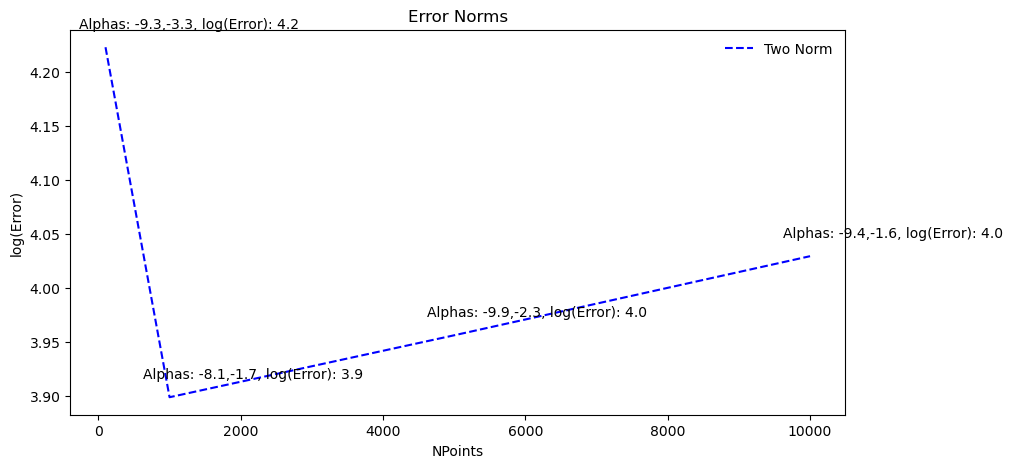

In [73]:
# Plotting both errors as function of M
fig = plt.figure(figsize=[10,5])

#####################
plt.title("Error Norms")

# Plot the error norm with their values
plt.plot(nPoints,np.log(mean_er),label = "Two Norm",color="blue", linestyle="--")

for x,y,z,e in zip(nPoints,mean_alpha1,mean_alpha2,mean_er):
    plt.annotate(f"Alphas: {y:0.1f},{z:0.1f}, log(Error): {np.log(e):0.1f}\n\n",(x,np.log(e)),textcoords="offset points",xytext=(60,-10),ha='center')


plt.xlabel("NPoints")
plt.ylabel("log(Error)")


plt.legend(frameon = False)
plt.show()